# Semi-discrete optimal transport tools

This jupyter worksheet provides tools for for computing semi-discrete optimal transport maps. We use **scipy** which provides n-dimensional Delaunay via [qHull](http://www.qhull.org/), **numpy** and **matplotlib** as classical tools for applied maths, **shapely** and **descartes** for polygon manipulation and display.

In [4]:
%matplotlib inline
from scipy.spatial import Delaunay
import shapely.geometry as geom
from descartes import PolygonPatch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
import random
import math

## Power diagrams as restricted Voronoi diagrams

semi discrete transport maps are equivalent to power diagrams in the semi discrete setting. We therefore need power diagrams. Power diagrams themselves are equivalent to restricter voronoi diagrams : given $n$ sites $S = \left\{\mathbf{s}_i\right\}_{i = 0}^{n-1} \subset \mathbb{R}^d$ and associated weights $W = \left\{w_i\right\}_{i=0}^{n-1} \subset \mathbb{R}$, the power cell of a site i $P(S,W,i)$ is defined as

$$
P(S,W,i) = \left\{x \in \mathbb{R}^d, \lVert \mathbf{x} - \mathbf{s}_i\rVert^2 - w_i < \lVert \mathbf{x} - \mathbf{s}_j \rVert^2 - w_j \quad\mbox{for all}\quad j \neq i \right\}.
$$

First notice that adding a constant quantity to all the weights has no effect on the diagram. We can therefore assume without loss of generality that every weight is negative. Given non negative weights, substracting the maximal weight to every weight gives an equivalent power diagram with negative weights.

Second, assuming that $w_i$ is negative, we can define $z_i = \sqrt{-w_i}$ and notice that 

$$
\begin{aligned}
\lVert (\mathbf{x},0) - (\mathbf{s}_i, z_i) \rVert^2
&= \lVert \mathbf{x} - \mathbf{s}_i \rVert^2 + (0 - z_i)^2 \\
&= \lVert \mathbf{x} - \mathbf{s}_i \rVert^2 - w_i \\
\end{aligned}
$$

We can therefore lift all the sites adding $z_i$ as the additional $z$ coordinate, and compute the intersection between the Voronoi cells of the lifted sites and the plane $z=0$. This is what the following code does.

## Restricting Voronoi diagram

We first provide an implementation of the Sutherland-Hodgman algorithm to clip a convex polygon by a bisector plane.

In [3]:
def segment_bisector_intersect(pt0, pt1, site0, site1):
    # intersection between the segment between pt0 and pt1
    # and the bisector seperating the sites site0 and site1
    #
    # the intersection p is defined as pt0 + t(pt1 - pt0) with t in [0,1]
    # the intersection is the point such that p is on the bisector
    # p.(site1 - site0) = 0.5*(site1 +site0).(site1 - site0)
    
    t = np.dot(site1 + site0 - 2 * pt0, site1 - site0)
    t /= 2 * np.dot(pt1 - pt0, site1 - site0)
    if t >= 0 and t <= 1:
        return pt0 + t * (pt1 - pt0)
    return None

In [2]:
def clip_convex_by_bisector(polygon, site0, site1):
    # Sutherland Hodgman algorithm
    #
    # polygon is the array of vertices of the polygon
    # the idea is to loop on the vertices, keep those 
    # on the good side of the bisector and leave those
    # outside. Each portion of outside points is replaced
    # by the pair of intersection points between the sides 
    # of the polygon crossing the bisector and the bisector.
    
    size = len(polygon)
    
    # the distance to the sites provides the "in or out" information
    d0 = [np.linalg.norm(p - site0) for p in polygon]
    d1 = [np.linalg.norm(p - site1) for p in polygon]
    
    # storage for the resulting polygon
    result = []
    for i in range(size):
        # previous vertex to determine if the segment crosses the bisector
        previ = (i + size - 1) % size
        if d0[i] < d1[i]:
            #the vertex is inside
            if d0[previ] > d1[previ]:
                #the previous was outside
                # add the intersection
                inter = segment_bisector_intersect(polygon[previ], polygon[i], site0, site1)
                result.append(inter)
            result.append(polygon[i])
        else:
            #the vertex is outside
            if d0[previ] < d1[previ]:
                #the previous was inside
                #add the intersection
                inter = segment_bisector_intersect(polygon[previ], polygon[i], site0, site1)
                result.append(inter)
    return np.array(result)
            

In [5]:
def clip_by_bisector(shape, site0, site1):
    # shapely provides a polygon / polygon intersection, no required convexity
    # we convert the bisector to a polygon by clipping the shape's bbox
    if shape.is_empty:
        return shape
    bbox = geom.box(*shape.bounds)
    
    # the shape is 2D but the diagram is potentially of a higher dimension, restricted to xy
    lifted_bbox = np.hstack([
        np.array(bbox.exterior)[:-1],
        np.zeros((4, len(site0) - 2))
    ])
    
    # bounding box intersection with the sites bisector
    clipped = clip_convex_by_bisector(lifted_bbox, site0, site1)
    
    # generic shapely clipping 
    if len(clipped) > 2:
        return shape.intersection(geom.Polygon(clipped))
    
    # empty polygon if the bbox was outside the bisector
    return geom.Polygon()

In [8]:
def clip_by_cell(shape, delaunay, index):
    # restricted cell computation
    # iteratively clipping by the bisectors of every Delaunay neighbor
    point = delaunay.points[index]
    nranges, nindices = delaunay.vertex_neighbor_vertices
    neighbors = nindices[nranges[index]:nranges[index+1]]
    result = shape
    for n in neighbors:
        result = clip_by_bisector(result, point, delaunay.points[n])
    return result

In [9]:
def restricted_voronoi(shape, sites):
    # Voronoi diagram restricted to a 2D shape
    # provides an iterator on the restricted cells
    delaunay = Delaunay(sites)
    for i,_ in enumerate(sites):
        yield clip_by_cell(shape, delaunay, i)

In [10]:
domain = geom.Point(0.5,0.5).buffer(0.5).difference(geom.Point(0.5,0.75).buffer(0.25))
sites = np.random.random_sample([100, 2])
cells = list(restricted_voronoi(domain, sites))

In [11]:
def plot_cells(cells, sites = None, radii = None, ax = None):
    # utility to plot a set of polygons.
    if ax is None:
        _,ax= plt.subplots(figsize=(5,5))
        
    ax.set_axis_off()

    cmap = plt.cm.get_cmap('hsv', 100)
    for i,cell in enumerate(cells):
        if not cell.is_empty:
            patch = PolygonPatch(cell, fc=cmap(i % 100))
            ax.add_patch(patch)
            
    if sites is not None:
        colors = [cmap(i%100) for i,_ in enumerate(sites)]
        ax.scatter(sites[:,0], sites[:,1], s = radii, c = colors, zorder=2, edgecolor='black')
            

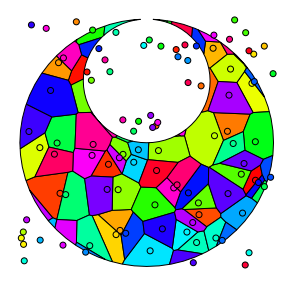

In [12]:
plot_cells(cells, sites)

## Lloyd iterations for testing

To test our restricted Voronoi daigram, we implement the Lloyd algorithm, iteratively moving the sites to their cell barycenter.

In [13]:
def lloyd_step(shape, sites):
    cells = restricted_voronoi(shape, sites)
    return np.stack([ 
        # the site is not moved if its restricted cell is empty
        site if cell.is_empty else np.array(cell.centroid)
        for site,cell in zip(sites,cells)
    ])

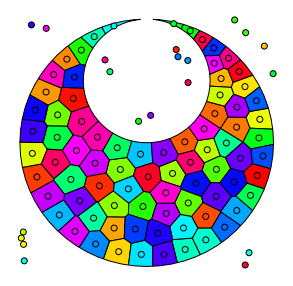

In [14]:
lloyd_sequence = [sites]

for i in range(40):
    sites = lloyd_step(domain, sites)
    lloyd_sequence.append(sites)

cells = list(restricted_voronoi(domain, sites))
plot_cells(cells, sites)

In [15]:
def animate_diagram(domain, site_sequence):
    # convert a sequence of sites to a video of the corresponding restricted Voronoi diagram sequence
    fig, ax = plt.subplots(figsize=(5,5))
    plt.close()
        
    def update(frame):
        ax.clear()
        sites = site_sequence[frame]
        cells = list(restricted_voronoi(domain, sites))
        plot_cells(cells, sites, ax = ax)
                
    ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(site_sequence), interval=80, repeat=True)
    return HTML(ani.to_html5_video())

In [22]:
animate_diagram(domain, lloyd_sequence)

## Power diagram via restricted Voronoi diagram

Lifting the sites as described above, we compute the power cells.

In [18]:
def restricted_power_cells(domain, sites, weights):
    # ensuring that all weights are negative
    max_weight = np.max(weights)
    
    if np.all(weights == max_weight):
        # failsafe when all weights are identical
        # avoids a qhull exception
        lifted_sites = sites
    else:
        lifted_sites = np.hstack([
            sites,
            np.sqrt(max_weight - weights)[:,np.newaxis]
        ])
    return restricted_voronoi(domain, lifted_sites)

In [19]:
weights = (np.random.random_sample(len(sites)) - 0.5) / 100

In [20]:
pcells = list(restricted_power_cells(domain, sites, weights))

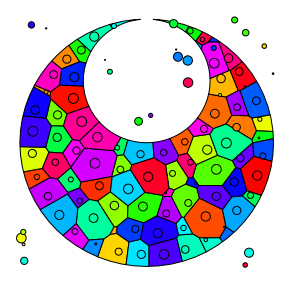

In [21]:
plot_cells(pcells, sites, 10000*(weights - np.min(weights)))